
# Studying Repelling-Attracting Metropolis Algorithm for Multimodality’ based on paper by ‘Hyungsuk Tak’ by applying on Sensor network

Improvements in sensing technology and wireless communication are rapidly increasing the importance of sensor networks for a wide variety of application domains. Sensor localization is the process of obtaining the estimates of each sensors position as well as accurately represenitng the uncertianity of estimates.

Here we consider an example from Ilher et all.(2005). This example searchfor unknown sensor lcations within a network using the noisy distance data.

## Model and Likelihood Function

We observe "noisy" distance estimates between pairs of sensors. Further, there is a probability that no distance measurement is made. The probability is proportional to the distance between the two sensors.

Let $x_{i} = (x_{i1},x_{i2})$ be the Cartesian coordinates of sensor $i$. This data is stored in the rows of the matrix `X`.

Let $W_{ij} = 1$ if a measurement is made between sensors $i$ and $j$ and $0$ if not. The article assumes
$$ W_{ij} \sim Bernoulli(e^{-||x_i - x_j||^2/(2*0.3^2)})$$.

Given that a measurement is made, there is Normal measurement error
$$ y_{ij} | w_{ij}=1 \sim N(||x_i-x_j||,0.02^2).$$
On average the measurement is correct. The standard deviation of the measurement is $0.02$.



We now have all the data loaded. The plot in the paper which summarizes the data is:

(requires internet connection to view)

<img src="https://david-jones-statistics.github.io/statcomp/lectures/topic3-optimization/optimization_sensor.png">

In [36]:
# Observation indicators from the fifth sensor (1st column) to the first four sensors
# and those from the sixth sensor (2nd column) to the first four sensors.
Ob <- matrix(c(1, 0, 1, 0, 1, 0, 1, 0), ncol = 2)
Ob

1,1
0,0
1,1
0,0


In [37]:
# Observation indicators among the first four sensors.
Os <- matrix(c(0, 0, 0, 1,
               0, 0, 1, 1,
               0, 1, 0, 0,
               1, 1, 0, 0), ncol = 4)
Os

0,0,0,1
0,0,1,1
0,1,0,0
1,1,0,0


In [38]:
# Each row indicates the location of the known sensors (5th and 6th).
Xb <- matrix(c(0.5, 0.3, 0.3, 0.7), ncol = 2)
Xb

0.5,0.3
0.3,0.7


In [39]:
# Each row indicates the location of the unknown sensors (1st, 2nd, 3rd, and 4th).
Xs <- matrix(c(0.5748, 0.0991, 0.2578, 0.8546, 
               0.9069, 0.3651, 0.1350, 0.0392), ncol = 2)
Xs

0.5748,0.9069
0.0991,0.3651
0.2578,0.1350
0.8546,0.0392


In [40]:
# The observed distances from the fifth sensor (1st column) to the first four sensors
# and those from the sixth sensor (2nd column) to the first four sensors.
##if data is not observed, the distance value is zero.
Yb <- matrix(c(0.6103, 0, 0.2995, 0, 
               0.3631, 0, 0.5656, 0), ncol = 2)
Yb

0.6103,0.3631
0.0000,0.0000
0.2995,0.5656
0.0000,0.0000


In [41]:
# Observed distances among the first four sensors.
#if data is not observed, the distance value is zero.
Ys <- matrix(c(0, 0, 0, 0.9266,
               0, 0, 0.2970, 0.8524,
               0, 0.2970, 0, 0,
               0.9266, 0.8524, 0, 0), ncol = 4)
Ys

0.0000,0.0000,0.000,0.9266
0.0000,0.0000,0.297,0.8524
0.0000,0.2970,0.000,0.0000
0.9266,0.8524,0.000,0.0000


In [42]:
#This norm function calculatess the distance between location a and location b
norm2 <- function(loca, locb) {
  sqrt(sum((loca - locb)^2))
}

# Posterior Density function

We are creating a **l.target function** which returns the posterior density. 

Write equation on page no. 18

This function consists of four terms: 

1. The First.term is the 2nd and 3rd term in the likelihood function where i the location of 5th an 6th points (x5,x6) and j is the location first four points (x1,x2,x3,x4)

2. The Second.term is the 2nd and 3rd term in the likelihood function where i and j are the location of first 4 points (x1,x2,x3,x4)

3. First.obs.term is the first term in the likelihood function, where i ranges from 5th and 6th location points and j ranges from 1-4 location points.

4.  Second.obs.term is the first term in the likelihood function, where i and j both ranges from 1-4 location points.

*First.obs.term and Second.obs.term is generated using a normal density function, with mean as given in the likelihood equation and standard deviation = 0.2*

*The log likelihood is calcualated by adding all the four terms.*

*The log posterior is calculated by adding log likelihood and the second term in the posterior equation mentioned in the above (1) equation.*



In [43]:
######## Target joint posterior density

l.target <- function(loc, R = 0.3, sigma = 0.02, Ob, Os, Xb, Xs, Yb, Ys) {

  First.term <- NULL
  for (i in 1 : 2) {
    TEMP <- sapply(1 : 4, function(j) {
      exp(-norm2(Xb[i, ], loc[(2 * j -1) : (2 * j)])^2 / 2 / R^2 * Ob[j, i]) *
      (1 - exp(-norm2(Xb[i, ], loc[(2 * j -1) : (2 * j)])^2 / 2 / R^2))^(1 - Ob[j, i]) 
    })
    First.term <- c(First.term, TEMP)
  }

  Second.term <- NULL
  for (i in 1 : 3) {
    TEMP <- sapply((i + 1) : 4, function(j) {
      exp(-norm2(loc[(2 * i -1) : (2 * i)], 
                 loc[(2 * j -1) : (2 * j)])^2 / 2 / R^2 * Os[i, j]) *
      (1 - exp(-norm2(loc[(2 * i -1) : (2 * i)], 
                      loc[(2 * j -1) : (2 * j)])^2 / 2 / R^2))^(1 - Os[i, j]) 
    })
    Second.term <- c(Second.term, TEMP)
  }

  First.obs.term <- NULL
  for (i in 1 : 2) {
    TEMP <- sapply(1 : 4, function(j) {
      dnorm(Yb[j, i], mean = norm2(Xb[i, ], loc[(2 * j -1) : (2 * j)]), 
                      sd = sigma)^Ob[j, i]
    })
    First.obs.term <- c(First.obs.term, TEMP)
  }

  Second.obs.term <- NULL
  for (i in 1 : 3) {
    TEMP <- sapply((i + 1) : 4, function(j) {
      dnorm(Ys[i, j], mean = norm2(loc[(2 * i -1) : (2 * i)], 
                                   loc[(2 * j -1) : (2 * j)]), 
                      sd = sigma)^Os[i, j]
    })
    Second.obs.term <- c(Second.obs.term, TEMP)
  }

  log.lik <- sum(log(c(First.term, Second.term, First.obs.term, Second.obs.term)))
  post <- log.lik + sum(dnorm(loc, mean = rep(0, 8), sd = rep(10, 8), log = TRUE))
  post

}


# RAM ALGORITHM

We write a function that iterates through 1 run of repealling attracting metropolis algorithm.

1. The first step is setting an initail value of the parameters **x.c** and an **auzillary variable z.c**.

2. **The second step is downhill step. We repeateadly sample two random variables from a normal proposal distribution untill a downward step in density is acheived. We call this a x.p1**.

3. Then in the next step we repeatedly sample again from a **normal proposal distribution** untill an **upward step in density** is acheived. We call this as **x.p2**

4. Next we again go down in density from the previous point to create an **axuillary variable** and got z.

5. Now we accept **x.p2 with a probability** as given in the equation.

*As last we return the final parameter x.p2, the auzillary variable z, the no. of downhill proposal (N.d), No. of uphill proposal (N.u), the number of downlhill proposal of auzillary variable (N.z), and average number of target density evaluation at each iteration (N.\Pi)*



In [44]:
######## RAM

ram.kernel <- function(current.location, current.aux, loc.number, scale) {

  eps <- 10^(-308)
  accept <- 0
  x.c <- current.location 
  log.x.c.den <- l.target(x.c, 0.3, 0.02, Ob, Os, Xb, Xs, Yb, Ys)
  x.c.den <- exp(log.x.c.den)
  z.c <- current.aux
  log.z.c.den <- l.target(z.c, 0.3, 0.02, Ob, Os, Xb, Xs, Yb, Ys)
  z.c.den <- exp(log.z.c.den)

  # downhill
  x.p1 <- x.c
  x.p1[(2 * loc.number - 1) : (2 * loc.number)] <- x.p1[(2 * loc.number - 1) : (2 * loc.number)] + 
                                                   rnorm(2, 0, scale)
  log.x.p1.den <- l.target(x.p1, 0.3, 0.02, Ob, Os, Xb, Xs, Yb, Ys)
  x.p1.den <- exp(log.x.p1.den)
  N.d <- 1
  while (-rexp(1) > log(x.c.den + eps) - log(x.p1.den + eps)) {
    x.p1 <- x.c
    x.p1[(2 * loc.number - 1) : (2 * loc.number)] <- x.p1[(2 * loc.number - 1) : (2 * loc.number)] + 
                                                     rnorm(2, 0, scale)
    log.x.p1.den <- l.target(x.p1, 0.3, 0.02, Ob, Os, Xb, Xs, Yb, Ys)
    x.p1.den <- exp(log.x.p1.den)
    N.d <- N.d + 1
  }

  # uphill
  x.p2 <- x.p1
  x.p2[(2 * loc.number - 1) : (2 * loc.number)] <- x.p2[(2 * loc.number - 1) : (2 * loc.number)] + 
                                                   rnorm(2, 0, scale)
  log.x.p2.den <- l.target(x.p2, 0.3, 0.02, Ob, Os, Xb, Xs, Yb, Ys)
  x.p2.den <- exp(log.x.p2.den)
  N.u <- 1
  while (-rexp(1) > log(x.p2.den + eps) - log(x.p1.den + eps)) {
    x.p2 <- x.p1
    x.p2[(2 * loc.number - 1) : (2 * loc.number)] <- x.p2[(2 * loc.number - 1) : (2 * loc.number)] + 
                                                     rnorm(2, 0, scale)
    log.x.p2.den <- l.target(x.p2, 0.3, 0.02, Ob, Os, Xb, Xs, Yb, Ys)
    x.p2.den <- exp(log.x.p2.den)
    N.u <- N.u + 1
  }

  # downhill for N.d
  N.dz <- 1     # number of total downhill trials for estimate
  z <- x.p2
  z[(2 * loc.number - 1) : (2 * loc.number)] <- z[(2 * loc.number - 1) : (2 * loc.number)] + 
                                                rnorm(2, 0, scale)
  log.z.den <- l.target(z, 0.3, 0.02, Ob, Os, Xb, Xs, Yb, Ys)
  z.den <- exp(log.z.den)
  while (-rexp(1) > log(x.p2.den + eps) - log(z.den + eps)) {
    z <- x.p2
    z[(2 * loc.number - 1) : (2 * loc.number)] <- z[(2 * loc.number - 1) : (2 * loc.number)] + 
                                                  rnorm(2, 0, scale)
    log.z.den <- l.target(z, 0.3, 0.02, Ob, Os, Xb, Xs, Yb, Ys)
    z.den <- exp(log.z.den)
    N.dz <- N.dz + 1
  }

  # accept or reject the proposal
  min.nu <- min(1, (x.c.den + eps) / (z.c.den + eps))
  min.de <- min(1, (x.p2.den + eps) / (z.den + eps))
  l.mh <- log.x.p2.den - log.x.c.den + log(min.nu) - log(min.de)

  if (l.mh > -rexp(1)) {
    x.c <- x.p2
    z.c <- z
    accept <- 1
  }

  c(x.c, z.c, N.d, N.u, N.dz, accept)
}


# MHWG - metorpolis hastings with gibbs.



We define a function that runs the ram alogrithm for (n.sample + n.burn) times.

In a single iteration the values of the 8 parameters are updated ssequentiallly 2 at a ime. 

The function returns the list with the posterior distribution x, N.d, N.u, N.c

N.d - number of downhill proposal for the RAM.

N.u is  number of uphill proposal for the RAM.

N.z is number of downhill proposal for auxillary variable.

In [45]:

MHwG.RAM <- function(initial.loc, initial.aux, jump.scale, 
             Ob, Os, Xb, Xs, Yb, Ys, n.sample = 10, n.burn = 10) {

  print(Sys.time())
  n.total <- n.sample + n.burn
  accept <- matrix(0, nrow = n.total, ncol = 4)
  out <- matrix(NA, nrow = n.total, ncol = 8)
  loc.t <- initial.loc
  aux.t <- initial.aux
  Nd <- matrix(NA, nrow = n.total, ncol = 4)
  Nu <- matrix(NA, nrow = n.total, ncol = 4)
  Nz <- matrix(NA, nrow = n.total, ncol = 4)
  
  for (i in 1 : n.total) {
    for (j in 1 : 4) {
      TEMP <- ram.kernel(loc.t, aux.t, j, jump.scale[j])
      loc.t <- TEMP[1 : 8]
      aux.t <- TEMP[9 : 16]
      Nd[i, j] <- TEMP[17]
      Nu[i, j] <- TEMP[18]
      Nz[i, j] <- TEMP[19]
      accept[i, j] <- TEMP[20]
    }
    out[i, ] <- loc.t
  }
  print(Sys.time())
  list(x = out[-c(1 : n.burn), ], 
       accept = accept[-c(1 : n.burn), ],
       N.d = Nd[-c(1 : n.burn), ],
       N.u = Nu[-c(1 : n.burn), ],
       N.z = Nz[-c(1 : n.burn), ])

}


In [46]:
#j.scale is used to set the standard deviation of normal processal function
#We select the same standard deviation of 1.08 for the four unknown locations.

j.scale <- rep(1.08, 4)

Running the program for 20000 time and removing the first 2000

The sample size used in this project is 
"sample.size = 200000" and "burn.size = 20000".

In [47]:
library(microbenchmark)

In [48]:
res.ram <- MHwG.RAM(runif(8), runif(8), jump.scale = j.scale, 
                                Ob, Os, Xb, Xs, Yb, Ys, 
                                n.sample = 200000, n.burn = 20000)


[1] "2020-04-19 18:09:48 CDT"
[1] "2020-04-19 20:16:57 CDT"


In [ ]:
out <- microbenchmark(res.ram)
summary(out)

The sample size used in this project is 
"sample.size = 20000000" and "burn.size = 20000".

In [ ]:
system.time(res.ram.den <- MHwG.RAM(runif(8), runif(8), jump.scale = j.scale, 
                                Ob, Os, Xb, Xs, Yb, Ys, 
                                n.sample = 20000000, n.burn = 20000))
# The sample size used in the article is 
# "sample.size = 20000000" and "burn.size = 20000".

In [ ]:
out1 <- microbenchmark(res.ram.den)
summary(out1)

In [ ]:

######## Summary

# Table 4

##RAM Summary
colMeans(res.ram$accept)
colMeans(res.ram$N.d)
colMeans(res.ram$N.u)
colMeans(res.ram$N.z)



In [ ]:

# Figure 5

par(mfrow = c(4, 3), font = 2, font.lab = 2, font.axis = 2, cex = 1.2,
    mai = c(0.7, 0.9, 0.7, 0.3), mgp = c(2.5, 0.5, 0), las = 1)




plot(res.ram$x[, c(1, 2)], pch = 46, xlim = c(-0.2, 0.8), ylim = c(0.3, 1.1),
     xlab = "", ylab = "", main = "")
title(expression(bold(paste("RAM: ", x[1]))))
mtext(side = 1, text = expression(bold(x[11])), line = 1.6, cex = 1.2)
mtext(side = 2, text = expression(bold(x[12])), line = 1.9, cex = 1.2)
abline(v = 0.5748, lty = 2, lwd = 1)
abline(h = 0.9069, lty = 2, lwd = 1)



plot(res.ram$x[, c(3, 4)], pch = 46, xlim = c(-0.3, 1.3), ylim = c(-0.5, 1.1),
     xlab = "", ylab = "", main = "")
title(expression(bold(paste("RAM: ", x[2]))))
mtext(side = 1, text = expression(bold(x[21])), line = 1.6, cex = 1.2)
mtext(side = 2, text = expression(bold(x[22])), line = 1.9, cex = 1.2)
abline(v = 0.0991, lty = 2, lwd = 1)
abline(h = 0.3651, lty = 2, lwd = 1)




plot(res.ram$x[, c(5, 6)], pch = 46, xlim = c(0, 1), ylim = c(-0.1, 0.65),
     xlab = "", ylab = "", main = "")
title(expression(bold(paste("RAM: ", x[3]))))
mtext(side = 1, text = expression(bold(x[31])), line = 1.6, cex = 1.2)
mtext(side = 2, text = expression(bold(x[32])), line = 1.9, cex = 1.2)
abline(v = 0.2578, lty = 2, lwd = 1)
abline(h = 0.1350, lty = 2, lwd = 1)



plot(res.ram$x[, c(7, 8)], pch = 46, xlim = c(-1, 2), ylim = c(-0.5, 2),
     xlab = "", ylab = "", main = "")
title(expression(bold(paste("RAM: ", x[4]))))
mtext(side = 1, text = expression(bold(x[41])), line = 1.6, cex = 1.2)
mtext(side = 2, text = expression(bold(x[42])), line = 1.9, cex = 1.2)
abline(v = 0.8546, lty = 2, lwd = 1)
abline(h = 0.0392, lty = 2, lwd = 1)



In [ ]:
# Figure 6

par(mfrow = c(4, 3), font = 2, font.lab = 2, font.axis = 2, cex = 1.2,
    mai = c(0.7, 0.9, 0.7, 0.3), mgp = c(2.5, 0.5, 0), las = 1)



hist(res.ram$x[, 1], 50, prob = TRUE, main = "", xlab = "", ylab = "",
     ylim = c(0, 11), xlim = c(-0.2, 0.75))
title(expression(bold(paste("RAM: ", x[11]))))
mtext(side = 1, text = expression(bold(x[11])), line = 1.6, cex = 1.2)
mtext(side = 2, text = "Density", line = 1.7, cex = 1.2, las = 0)
index <- which(!is.na(res))
lines(density(res.ram.den$x[, 1]), lwd = 1.5)
legend("top", c(expression(bold("Marginal dist.")), 
                    expression(bold("True location"))), lwd = 3, 
       bty = "n", seg.len = 0.9, cex = 0.9, lty = c(1, 3))
abline(v = 0.5748, lty = 2, lwd = 2)



hist(res.ram$x[, 3], 30, prob = TRUE, main = "", xlab = "", ylab = "",
     ylim = c(0, 3), xlim = c(-0.15, 1.3))
title(expression(bold(paste("RAM: ", x[21]))))
mtext(side = 1, text = expression(bold(x[21])), line = 1.6, cex = 1.2)
mtext(side = 2, text = "Density", line = 1.8, cex = 1.2, las = 0)
legend("top", c(expression(bold("Marginal dist.")), 
                    expression(bold("True location"))), lwd = 3, 
       bty = "n", seg.len = 0.9, cex = 0.9, lty = c(1, 3))
lines(density(res.ram.den$x[, 3]), lwd = 1.5)
abline(v = 0.1, lty = 2, lwd = 2)



hist(res.ram$x[, 5], 30, prob = TRUE, main = "", xlab = "", ylab = "",
     ylim = c(0, 15), xlim = c(0.15, 0.85))
mtext(side = 1, text = expression(bold(x[31])), line = 1.6, cex = 1.2)
mtext(side = 2, text = "Density", line = 1.7, cex = 1.2, las = 0)
index <- which(!is.na(res))
title(expression(bold(paste("RAM: ", x[31]))))
lines(density(res.ram.den$x[, 5]), lwd = 1.5)
legend("top", c(expression(bold("Marginal dist.")), 
                    expression(bold("True location"))), lwd = 3, 
       bty = "n", seg.len = 0.9, cex = 0.9, lty = c(1, 3))
abline(v = 0.2578, lty = 2, lwd = 2)




hist(res.ram$x[, 7], 30, prob = TRUE, main = "", xlab = "", ylab = "",
     ylim = c(0, 2.3), xlim = c(-1.1, 1.8))
mtext(side = 1, text = expression(bold(x[41])), line = 1.6, cex = 1.2)
mtext(side = 2, text = "Density", line = 1.7, cex = 1.2, las = 0)
title(expression(bold(paste("RAM: ", x[41]))))
lines(density(res.ram.den$x[, 7]), lwd = 1.5)
legend("topleft", c(expression(bold("Marginal dist.")), 
                    expression(bold("True location"))), lwd = 3, 
       bty = "n", seg.len = 0.9, cex = 0.9, lty = c(1, 3))
abline(v = 0.85, lty = 2, lwd = 2)



## Generating multimode density with the BFGS optimization technique and Comparing based on computation speed and other parameters.

In [ ]:
X <- cbind(c(0.57,0.10,0.26,0.85,0.50,0.30),c(0.91,0.37,0.14,0.04,0.30,0.70))
Y <- matrix(c(0,0,0,0.9266,0.6103,0.3631,
              0,0,0.2970,0.8524,0,0,
              0,0,0,0,0.2995,0.5656,
              0,0,0,0,0,0,
              0,0,0,0,0,0,
              0,0,0,0,0,0),nrow=6,byrow=TRUE)
Y <- Y + t(Y)
Y

In [ ]:
## create the W matrix
W <- 1*(Y!=0)
W
Xk <- X[5:6,]

In [ ]:
## this is L(x_1,x_2,x_3,x_4) above Equation 12 in paper
## note there is a typo in the paper, first exp should be
## to the W_ij power. corrected in this code
likelihood <- function(theta,Xk,Y){
  thetaX <- rbind(matrix(theta,nrow=length(theta)/2,byrow=TRUE),Xk) # columns filled first, Xk appended
  Xd <- as.matrix(dist(thetaX))
  temp <- -Xd^2 / (2*0.3^2) # Log prob. observe distance
  out <- W*(-(Y - Xd)^2 / (2*0.02^2) + temp) + (1-W)*log(1-exp(temp))
  return(sum(out[lower.tri(out)]))
}

In [ ]:
## we run the optimizer N times from
## random starting locations
N <- 500
soln <- array(0,dim=c(N,4,2))

maxit <- 1000
for(ii in 1:N){
  init <- runif(8,min=-0.5,max=1.5)
  a <- optim(init,likelihood,method="BFGS",Xk=Xk,Y=Y,control=list(maxit=maxit,fnscale=-1))
  soln[ii,,] <- matrix(a$par,ncol=2,byrow=TRUE)
}

In [ ]:
##Plot the results
plot(0,0,xlim=c(-.5,1.5),ylim=c(-.6,1.5),col=0,xlab="",ylab="")
pch_est <- c(0,1,2,5)
## make colors 1:4 transparent
cols <- rgb(t(col2rgb(1:6)),alpha=70,maxColorValue=255)
for(jj in 1:4){
  points(soln[,jj,1],soln[,jj,2],xlab="x_11",ylab="x_12",col=cols[jj],pch=pch_est[jj])
  points(X[jj,1],X[jj,2],col=jj,cex=2,pch=as.character(jj),font=2)
}
points(0.5,0.3,col=jj,cex=2,pch=as.character(5),font=2)
points(0.3,0.7,col=jj,cex=2,pch=as.character(6),font=2)
legend("topright",paste0("Sensor ",1:6),col=1:6,pch=pch_est)


# Checking RAM Algorithm for larger Sensor Network with more nodes.

In [16]:
set.seed(6)
X<- matrix(round(runif(18),2),ncol = 2)
X

0.61,0.06
0.94,0.64
0.26,0.92
0.38,0.10
0.81,0.30
0.98,0.77
0.96,0.26
0.76,0.52
0.51,0.68


          1         2         3         4         5         6         7
2 0.6673080                                                            
3 0.9284934 0.7353911                                                  
4 0.2334524 0.7779460 0.8287340                                        
5 0.3124100 0.3640055 0.8287943 0.4742362                              
6 0.8006248 0.1360147 0.7354590 0.8993887 0.4998000                    
7 0.4031129 0.3805260 0.9620811 0.6016644 0.1552417 0.5103920          
8 0.4838388 0.2163331 0.6403124 0.5663921 0.2256103 0.3330165 0.3280244
9 0.6280127 0.4318565 0.3465545 0.5943904 0.4841487 0.4785394 0.6155485
          8
2          
3          
4          
5          
6          
7          
8          
9 0.2968164

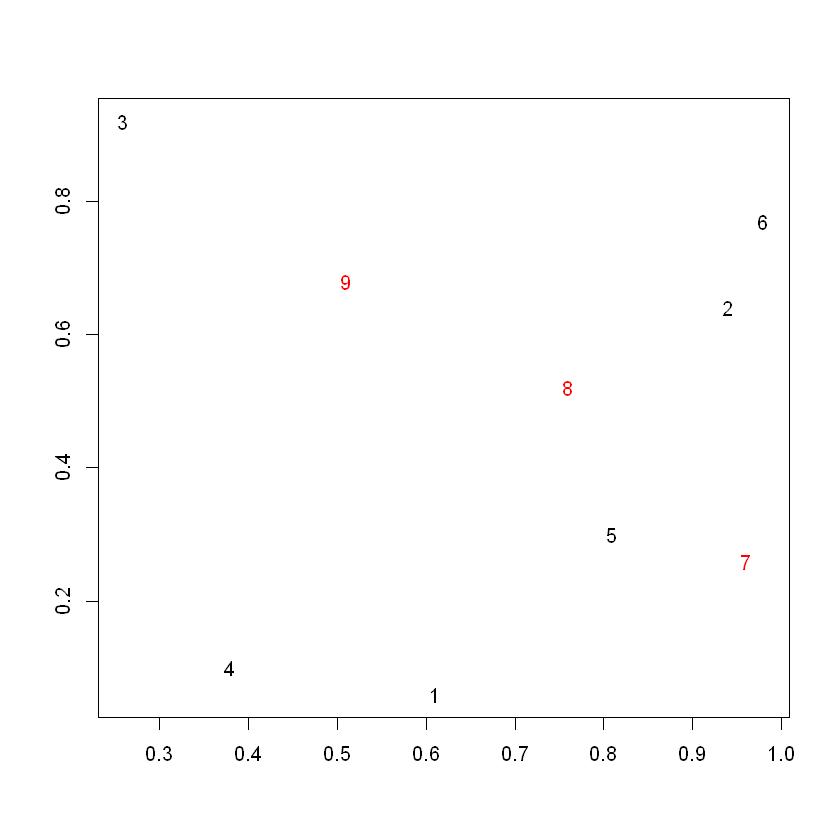

In [17]:
plot(X[,1],X[,2],pch=as.character(1:9),col=c(rep(1,6),rep(2,3)),xlab="",ylab="")
dist(X)

In [18]:
distance<- matrix(0,nrow = 9,ncol = 9)
distance

0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0


In [19]:
norm2 <- function(loca, locb) {
  sqrt(sum((loca - locb)^2))
}

for (i in 1:9){
  for (j in 1:9){
    distance[i,j]=norm2(X[i,],X[j,])
  }
}

In [20]:

#Add random error
obs_distance = distance + matrix(rnorm(81,0,0.02),nrow = 9)

for (i in 1:9){
  obs_distance[i:9,i]=0
}
obs_distance

0,0.6615224,0.9755775,0.2460622,0.2974950,0.7777182,0.3709119,0.4834160,0.6269919
0,0.0000000,0.7632596,0.8102852,0.3585266,0.1577072,0.3737629,0.2043447,0.4764003
0,0.0000000,0.0000000,0.8248640,0.8652859,0.7048791,0.9661798,0.6340951,0.3462770
0,0.0000000,0.0000000,0.0000000,0.4745209,0.8679138,0.5971775,0.5527594,0.5634425
0,0.0000000,0.0000000,0.0000000,0.0000000,0.4975181,0.1370496,0.2215692,0.4565510
0,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.4942298,0.3553525,0.5081369
0,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.3445444,0.6104501
0,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.2902908
0,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000


In [21]:
#Now we randomly remove some distance by randomly selecting 0 and 1
set.seed(1)
O <- matrix(rbinom(81,1,0.5),nrow=9)
O


0,0,0,0,1,1,0,0,0
0,0,1,1,0,0,0,1,0
1,0,1,0,1,0,0,0,0
1,1,0,0,0,1,1,0,1
0,0,1,1,1,1,1,1,1
1,1,0,0,1,0,0,0,0
1,0,0,0,1,1,1,1,1
1,1,0,1,1,0,0,0,1
1,1,0,1,1,0,0,1,0


In [22]:
for (i in 1:9){
  O[i:9,i]=0
}
O


0,0,0,0,1,1,0,0,0
0,0,1,1,0,0,0,1,0
0,0,0,0,1,0,0,0,0
0,0,0,0,0,1,1,0,1
0,0,0,0,0,1,1,1,1
0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,1,1
0,0,0,0,0,0,0,0,1
0,0,0,0,0,0,0,0,0


In [23]:
O <- O + t(O)
O


0,0,0,0,1,1,0,0,0
0,0,1,1,0,0,0,1,0
0,1,0,0,1,0,0,0,0
0,1,0,0,0,1,1,0,1
1,0,1,0,0,1,1,1,1
1,0,0,1,1,0,0,0,0
0,0,0,1,1,0,0,1,1
0,1,0,0,1,0,1,0,1
0,0,0,1,1,0,1,1,0


In [25]:
obs_distance

0,0.6615224,0.9755775,0.2460622,0.2974950,0.7777182,0.3709119,0.4834160,0.6269919
0,0.0000000,0.7632596,0.8102852,0.3585266,0.1577072,0.3737629,0.2043447,0.4764003
0,0.0000000,0.0000000,0.8248640,0.8652859,0.7048791,0.9661798,0.6340951,0.3462770
0,0.0000000,0.0000000,0.0000000,0.4745209,0.8679138,0.5971775,0.5527594,0.5634425
0,0.0000000,0.0000000,0.0000000,0.0000000,0.4975181,0.1370496,0.2215692,0.4565510
0,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.4942298,0.3553525,0.5081369
0,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.3445444,0.6104501
0,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.2902908
0,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000


In [26]:

Y = O*obs_distance
Y <- Y + t(Y)
Y

0.0000000,0.0000000,0.0000000,0.0000000,0.2974950,0.7777182,0.0000000,0.0000000,0.0000000
0.0000000,0.0000000,0.7632596,0.8102852,0.0000000,0.0000000,0.0000000,0.2043447,0.0000000
0.0000000,0.7632596,0.0000000,0.0000000,0.8652859,0.0000000,0.0000000,0.0000000,0.0000000
0.0000000,0.8102852,0.0000000,0.0000000,0.0000000,0.8679138,0.5971775,0.0000000,0.5634425
0.2974950,0.0000000,0.8652859,0.0000000,0.0000000,0.4975181,0.1370496,0.2215692,0.4565510
0.7777182,0.0000000,0.0000000,0.8679138,0.4975181,0.0000000,0.0000000,0.0000000,0.0000000
0.0000000,0.0000000,0.0000000,0.5971775,0.1370496,0.0000000,0.0000000,0.3445444,0.6104501
0.0000000,0.2043447,0.0000000,0.0000000,0.2215692,0.0000000,0.3445444,0.0000000,0.2902908
0.0000000,0.0000000,0.0000000,0.5634425,0.4565510,0.0000000,0.6104501,0.2902908,0.0000000


In [27]:

##Distance (binary) of 7th,8th and 9th to 1-6th 
Ob<-O[1:6,7:9]
Ob


0,0,0
0,1,0
0,0,0
1,0,1
1,1,1
0,0,0


In [28]:

Os<-O[1:6,1:6]
Os

0,0,0,0,1,1
0,0,1,1,0,0
0,1,0,0,1,0
0,1,0,0,0,1
1,0,1,0,0,1
1,0,0,1,1,0


In [29]:
#The true locations of 7th-9th sensor
Xb <- X[7:9,]
Xb

0.96,0.26
0.76,0.52
0.51,0.68


In [30]:

#The location of unknown sensors (1-6)
Xs <- X[1:6,]
Xs

0.61,0.06
0.94,0.64
0.26,0.92
0.38,0.10
0.81,0.30
0.98,0.77


In [31]:

#Distance of 7,8,9 to 1st 6 points and within 1st 6 points
Yb <- Y[1:6,7:9]
Yb
Ys <- Y[1:6,1:6]
Ys

0.0000000,0.0000000,0.0000000
0.0000000,0.2043447,0.0000000
0.0000000,0.0000000,0.0000000
0.5971775,0.0000000,0.5634425
0.1370496,0.2215692,0.4565510
0.0000000,0.0000000,0.0000000


0.0000000,0.0000000,0.0000000,0.0000000,0.2974950,0.7777182
0.0000000,0.0000000,0.7632596,0.8102852,0.0000000,0.0000000
0.0000000,0.7632596,0.0000000,0.0000000,0.8652859,0.0000000
0.0000000,0.8102852,0.0000000,0.0000000,0.0000000,0.8679138
0.2974950,0.0000000,0.8652859,0.0000000,0.0000000,0.4975181
0.7777182,0.0000000,0.0000000,0.8679138,0.4975181,0.0000000


In [32]:
######## Target joint posterior density
l.target <- function(loc, R = 0.3, sigma = 0.02, Ob, Os, Xb, Xs, Yb, Ys) {
  
  First.term <- NULL
  for (i in 1 : 3) {
    TEMP <- sapply(1 : 6, function(j) {
      exp(-norm2(Xb[i, ], loc[(2 * j -1) : (2 * j)])^2 / 2 / R^2 * Ob[j, i]) *
        (1 - exp(-norm2(Xb[i, ], loc[(2 * j -1) : (2 * j)])^2 / 2 / R^2))^(1 - Ob[j, i]) 
    })
    First.term <- c(First.term, TEMP)
  }  
  
  Second.term <- NULL
  for (i in 1 : 5) {
    TEMP <- sapply((i + 1) : 6, function(j) {
      exp(-norm2(loc[(2 * i -1) : (2 * i)], 
                 loc[(2 * j -1) : (2 * j)])^2 / 2 / R^2 * Os[i, j]) *
        (1 - exp(-norm2(loc[(2 * i -1) : (2 * i)], 
                        loc[(2 * j -1) : (2 * j)])^2 / 2 / R^2))^(1 - Os[i, j])  
    })
    Second.term <- c(Second.term, TEMP)
  }
  
  First.obs.term <- NULL
  for (i in 1 : 3) {
    TEMP <- sapply(1 : 6, function(j) {
      dnorm(Yb[j, i], mean = norm2(Xb[i, ], loc[(2 * j -1) : (2 * j)]), 
            sd = sigma)^Ob[j, i]
    })
    First.obs.term <- c(First.obs.term, TEMP)
  }
  
  Second.obs.term <- NULL
  for (i in 1 : 5) {
    TEMP <- sapply((i + 1) : 6, function(j) {
      dnorm(Ys[i, j], mean = norm2(loc[(2 * i -1) : (2 * i)], 
                                   loc[(2 * j -1) : (2 * j)]), 
            sd = sigma)^Os[i, j]
    })
    Second.obs.term <- c(Second.obs.term, TEMP)
  }  
  
  log.lik <- sum(log(c(First.term, Second.term, First.obs.term, Second.obs.term)))
  post <- log.lik + sum(dnorm(loc, mean = rep(0, 12), sd = rep(10, 12), log = TRUE))
  post
  
}

In [33]:

######## RAM

ram.kernel <- function(current.location, current.aux, loc.number, scale) {
  
  eps <- 10^(-308)
  accept <- 0 
  x.c <- current.location 
  log.x.c.den <- l.target(x.c, 0.3, 0.02, Ob, Os, Xb, Xs, Yb, Ys)
  x.c.den <- exp(log.x.c.den)
  z.c <- current.aux
  log.z.c.den <- l.target(z.c, 0.3, 0.02, Ob, Os, Xb, Xs, Yb, Ys)
  z.c.den <- exp(log.z.c.den)
  
  # downhill 
  x.p1 <- x.c
  x.p1[(2 * loc.number - 1) : (2 * loc.number)] <- x.p1[(2 * loc.number - 1) : (2 * loc.number)] + 
    rnorm(2, 0, scale)
  log.x.p1.den <- l.target(x.p1, 0.3, 0.02, Ob, Os, Xb, Xs, Yb, Ys)
  x.p1.den <- exp(log.x.p1.den)
  N.d <- 1
  while (-rexp(1) > log(x.c.den + eps) - log(x.p1.den + eps)) {
    x.p1 <- x.c 
    x.p1[(2 * loc.number - 1) : (2 * loc.number)] <- x.p1[(2 * loc.number - 1) : (2 * loc.number)] + 
      rnorm(2, 0, scale)
    log.x.p1.den <- l.target(x.p1, 0.3, 0.02, Ob, Os, Xb, Xs, Yb, Ys)
    x.p1.den <- exp(log.x.p1.den)
    N.d <- N.d + 1
  }
  
  # uphill
  x.p2 <- x.p1
  x.p2[(2 * loc.number - 1) : (2 * loc.number)] <- x.p2[(2 * loc.number - 1) : (2 * loc.number)] + 
    rnorm(2, 0, scale)
  log.x.p2.den <- l.target(x.p2, 0.3, 0.02, Ob, Os, Xb, Xs, Yb, Ys)
  x.p2.den <- exp(log.x.p2.den)
  N.u <- 1
  while (-rexp(1) > log(x.p2.den + eps) - log(x.p1.den + eps)) {
    x.p2 <- x.p1
    x.p2[(2 * loc.number - 1) : (2 * loc.number)] <- x.p2[(2 * loc.number - 1) : (2 * loc.number)] + 
      rnorm(2, 0, scale)
    log.x.p2.den <- l.target(x.p2, 0.3, 0.02, Ob, Os, Xb, Xs, Yb, Ys)
    x.p2.den <- exp(log.x.p2.den)
    N.u <- N.u + 1
  }
  
  # downhill for N.d
  N.dz <- 1     # number of total downhill trials for estimate
  z <- x.p2
  z[(2 * loc.number - 1) : (2 * loc.number)] <- z[(2 * loc.number - 1) : (2 * loc.number)] + 
    rnorm(2, 0, scale)
  log.z.den <- l.target(z, 0.3, 0.02, Ob, Os, Xb, Xs, Yb, Ys)
  z.den <- exp(log.z.den)
  while (-rexp(1) > log(x.p2.den + eps) - log(z.den + eps)) {
    z <- x.p2
    z[(2 * loc.number - 1) : (2 * loc.number)] <- z[(2 * loc.number - 1) : (2 * loc.number)] + 
      rnorm(2, 0, scale)
    log.z.den <- l.target(z, 0.3, 0.02, Ob, Os, Xb, Xs, Yb, Ys)
    z.den <- exp(log.z.den)
    N.dz <- N.dz + 1
  }
  
  # accept or reject the proposal
  min.nu <- min(1, (x.c.den + eps) / (z.c.den + eps))
  min.de <- min(1, (x.p2.den + eps) / (z.den + eps))
  l.mh <- log.x.p2.den - log.x.c.den + log(min.nu) - log(min.de)
  
  if (l.mh > -rexp(1)) {
    x.c <- x.p2
    z.c <- z
    accept <- 1
  }
  
  c(x.c, z.c, N.d, N.u, N.dz, accept)
}





In [ ]:
MHwG.RAM <- function(initial.loc, initial.aux, jump.scale, 
                     Ob, Os, Xb, Xs, Yb, Ys, n.sample = 10, n.burn = 10) {
  
  print(Sys.time())
  n.total <- n.sample + n.burn
  accept <- matrix(0, nrow = n.total, ncol = 6)
  out <- matrix(NA, nrow = n.total, ncol = 12)
  loc.t <- initial.loc
  aux.t <- initial.aux
  Nd <- matrix(NA, nrow = n.total, ncol = 6)
  Nu <- matrix(NA, nrow = n.total, ncol = 6)
  Nz <- matrix(NA, nrow = n.total, ncol = 6)
  
  for (i in 1 : n.total) {
    for (j in 1 : 6) {
      TEMP <- ram.kernel(loc.t, aux.t, j, jump.scale[j])
      loc.t <- TEMP[1 : 12]
      aux.t <- TEMP[13 : 24]
      Nd[i, j] <- TEMP[25]
      Nu[i, j] <- TEMP[26]
      Nz[i, j] <- TEMP[27]
      accept[i, j] <- TEMP[28]
    }
    out[i, ] <- loc.t
  }
  print(Sys.time())
  list(x = out[-c(1 : n.burn), ], 
       accept = accept[-c(1 : n.burn), ],
       N.d = Nd[-c(1 : n.burn), ],
       N.u = Nu[-c(1 : n.burn), ],
       N.z = Nz[-c(1 : n.burn), ])
  
}

j.scale <- rep(1.08, 6)



In [ ]:
res.ram <- MHwG.RAM(runif(12), runif(12), jump.scale = j.scale, 
                    Ob, Os, Xb, Xs, Yb, Ys, 
                    n.sample = 200000, n.burn = 20000)
res.ram


In [ ]:
plot(res.ram$x[, c(1, 2)], xlim = c(-0.2, 1), ylim = c(0, 1.1),
     xlab = "", ylab = "", main = "")
title(expression(bold(paste("RAM: ", x[1]))))
mtext(side = 1, text = expression(bold(x[11])), line = 1.6, cex = 1.2)
mtext(side = 2, text = expression(bold(x[12])), line = 1.9, cex = 1.2)
abline(v = Xs[1,1], lty = 2, lwd = 1)
abline(h = Xs[1,2], lty = 2, lwd = 1)